# Day 6: Weighted Least Squares & Robust Regression

## 🎯 Learning Objectives
- Handle heteroscedasticity in financial returns
- Apply WLS with volatility-based weights
- Use robust regression for outlier handling
- Compare methods on trading performance

---

## 📚 Theory

### Heteroscedasticity in Finance
Financial returns exhibit **volatility clustering**: high-volatility periods followed by high-volatility periods.

### Weighted Least Squares (WLS)
$$\hat{\beta}_{WLS} = \arg\min_\beta \sum_{i=1}^n w_i(y_i - x_i^T\beta)^2$$

**Weight Choices for Finance:**
- $w_i = 1/\sigma_i^2$ (inverse variance)
- $w_i = 1/|r_i|$ (inverse return magnitude)
- $w_i = \lambda^{T-i}$ (exponential decay for recency)

### Robust Regression Methods

| Method | Loss Function | Use Case |
|--------|--------------|----------|
| OLS | $\sum(y_i - \hat{y}_i)^2$ | Normal errors |
| LAD (L1) | $\sum|y_i - \hat{y}_i|$ | Heavy tails |
| Huber | Hybrid L1/L2 | Moderate outliers |
| RANSAC | Consensus | Extreme outliers |

### Huber Loss
$$L_\delta(r) = \begin{cases} \frac{1}{2}r^2 & |r| \leq \delta \\ \delta(|r| - \frac{1}{2}\delta) & |r| > \delta \end{cases}$$

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS', 'SPY']
end_date = datetime.now()
start_date = end_date - timedelta(days=7*365)  # More data to capture different regimes

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 1757 days, 6 assets


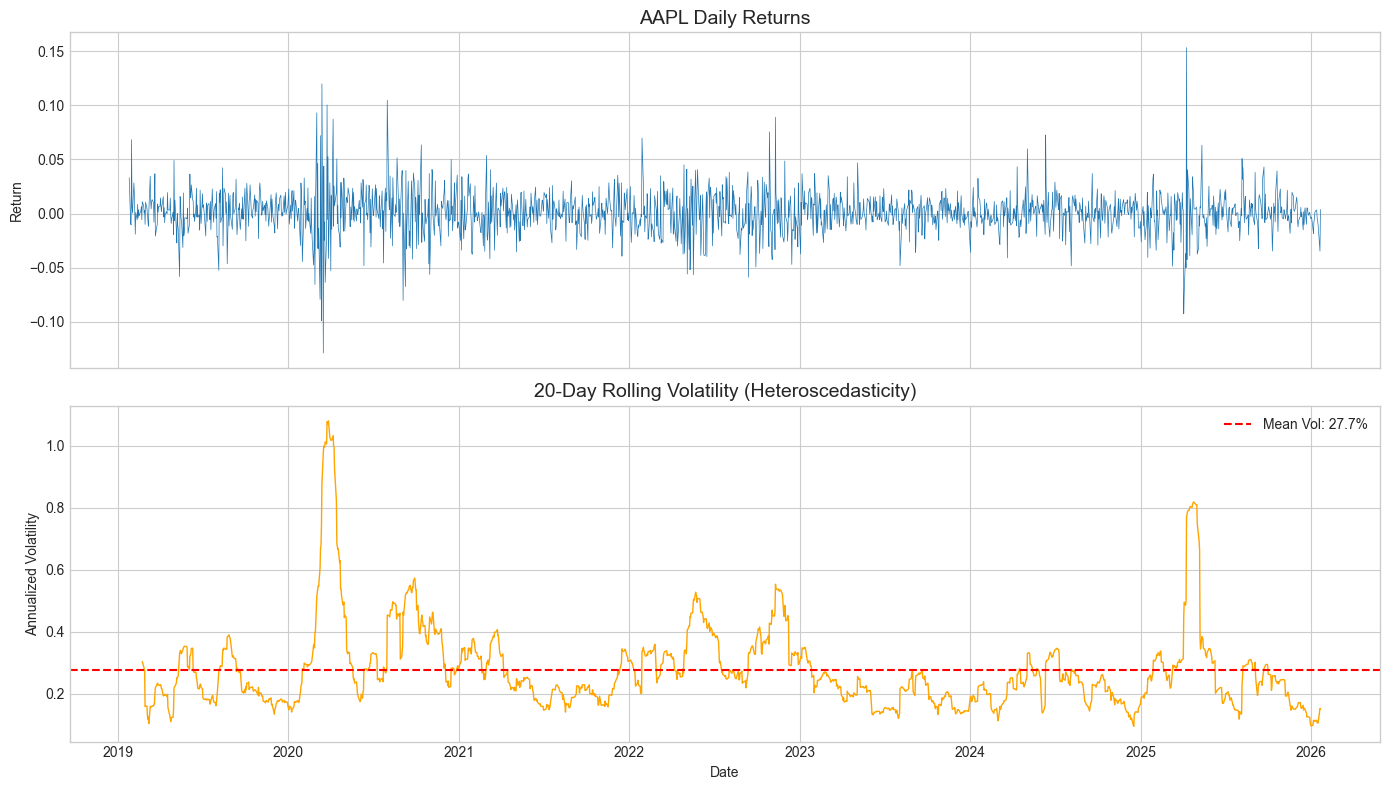


📊 Levene's Test for Heteroscedasticity: stat=168.48, p=0.0000
   Heteroscedasticity detected!


In [2]:
# Demonstrate heteroscedasticity
target = 'AAPL'
rolling_vol = returns[target].rolling(20).std() * np.sqrt(TRADING_DAYS)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Returns
axes[0].plot(returns.index, returns[target], linewidth=0.5)
axes[0].set_title(f'{target} Daily Returns', fontsize=14)
axes[0].set_ylabel('Return')

# Volatility
axes[1].plot(rolling_vol.index, rolling_vol.values, linewidth=1, color='orange')
axes[1].axhline(y=rolling_vol.mean(), color='r', linestyle='--', label=f'Mean Vol: {rolling_vol.mean():.1%}')
axes[1].set_title('20-Day Rolling Volatility (Heteroscedasticity)', fontsize=14)
axes[1].set_ylabel('Annualized Volatility')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

# Formal test for heteroscedasticity
from scipy.stats import levene
low_vol = returns[target][rolling_vol < rolling_vol.median()]
high_vol = returns[target][rolling_vol >= rolling_vol.median()]
stat, p_value = levene(low_vol.dropna(), high_vol.dropna())
print(f"\n📊 Levene's Test for Heteroscedasticity: stat={stat:.2f}, p={p_value:.4f}")
print(f"   {'Heteroscedasticity detected!' if p_value < 0.05 else 'Homoscedastic'}")

In [3]:
# Create features
df = pd.DataFrame(index=returns.index)

df['momentum_5'] = prices[target].pct_change(5)
df['momentum_20'] = prices[target].pct_change(20)
df['volatility_20'] = returns[target].rolling(20).std()
df['ma_ratio'] = prices[target] / prices[target].rolling(20).mean() - 1
df['spy_return'] = returns['SPY']

# For WLS weights
df['rolling_vol'] = returns[target].rolling(20).std()

# Target
df['target'] = returns[target].shift(-1)
df = df.dropna()

print(f"📊 Features: {len(df.columns)-2}")
print(f"📈 Samples: {len(df)}")

📊 Features: 5
📈 Samples: 1737


In [4]:
# Prepare data
feature_cols = ['momentum_5', 'momentum_20', 'volatility_20', 'ma_ratio', 'spy_return']
X = df[feature_cols]
y = df['target']
weights = 1 / (df['rolling_vol'] ** 2)  # Inverse variance weights
weights = weights / weights.sum() * len(weights)  # Normalize

# Train/Test split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
w_train = weights.iloc[:split_idx]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 1389, Test: 348


In [5]:
# OLS vs WLS comparison using statsmodels
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

# OLS
ols = sm.OLS(y_train, X_train_sm).fit()

# WLS with inverse variance weights
wls = sm.WLS(y_train, X_train_sm, weights=w_train).fit()

print("\n" + "="*60)
print("OLS vs WLS COEFFICIENT COMPARISON")
print("="*60)
print(f"\n{'Feature':<20} {'OLS':>12} {'WLS':>12} {'Diff %':>10}")
print("-" * 55)

feature_names = ['const'] + feature_cols
for i, feat in enumerate(feature_names):
    ols_coef = ols.params[i]
    wls_coef = wls.params[i]
    diff_pct = (wls_coef - ols_coef) / abs(ols_coef) * 100 if ols_coef != 0 else 0
    print(f"{feat:<20} {ols_coef:>12.6f} {wls_coef:>12.6f} {diff_pct:>10.1f}%")


OLS vs WLS COEFFICIENT COMPARISON

Feature                       OLS          WLS     Diff %
-------------------------------------------------------
const                    0.001425     0.001446        1.5%
momentum_5               0.000404    -0.000992     -345.9%
momentum_20              0.000964     0.000362      -62.5%
volatility_20           -0.000069    -0.000164     -137.7%
ma_ratio                -0.001052     0.000541      151.4%
spy_return              -0.002657    -0.000501       81.1%


In [6]:
# Robust Regression Methods
# Huber Regressor
huber = HuberRegressor(epsilon=1.35)  # Default epsilon
huber.fit(X_train_scaled, y_train)

# RANSAC (Random Sample Consensus)
ransac = RANSACRegressor(random_state=42)
ransac.fit(X_train_scaled, y_train)

# Standard OLS for comparison
ols_sklearn = LinearRegression()
ols_sklearn.fit(X_train_scaled, y_train)

print("\n✅ Trained: OLS, WLS, Huber, RANSAC")


✅ Trained: OLS, WLS, Huber, RANSAC


In [7]:
# Compare predictions
models = {
    'OLS': lambda X: ols.predict(sm.add_constant(X)),
    'WLS': lambda X: wls.predict(sm.add_constant(X)),
    'Huber': huber.predict,
    'RANSAC': ransac.predict
}

print("\n" + "="*70)
print("MODEL COMPARISON ON TEST SET")
print("="*70)

results = []
predictions = {}

for name, model_func in models.items():
    pred = model_func(X_test_scaled)
    predictions[name] = pred
    
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    dir_acc = (np.sign(pred) == np.sign(y_test)).mean()
    
    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Dir. Acc.': dir_acc
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


MODEL COMPARISON ON TEST SET
 Model        R²     RMSE      MAE  Dir. Acc.
   OLS -0.001686 0.018480 0.011852   0.500000
   WLS -0.001908 0.018482 0.011788   0.522989
 Huber -0.001717 0.018480 0.011765   0.511494
RANSAC -0.397532 0.021828 0.014389   0.508621


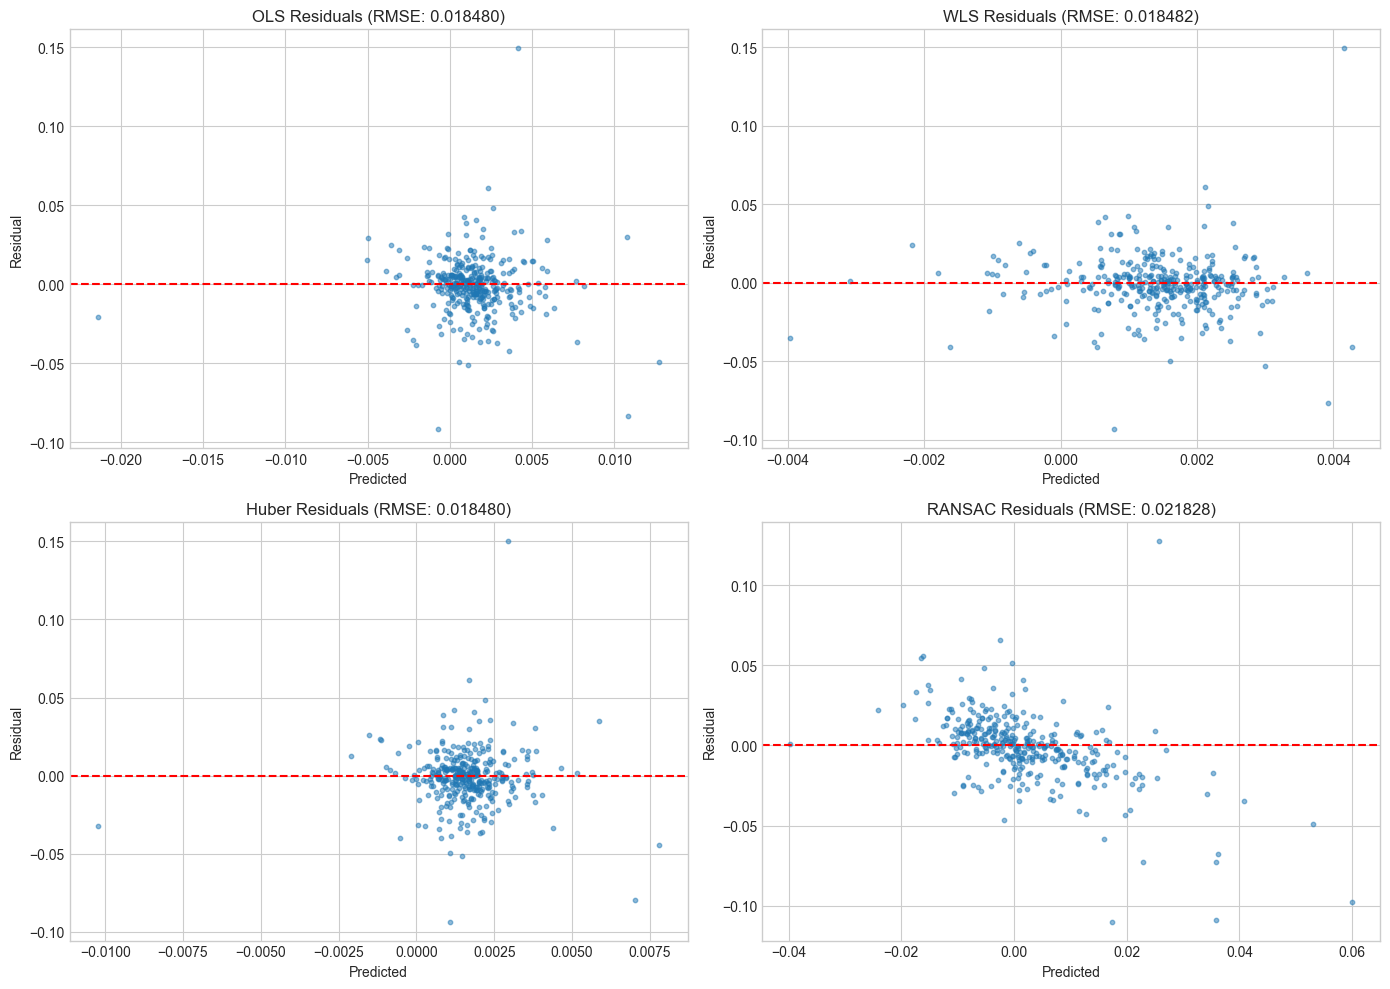

In [8]:
# Visualize outlier handling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (name, pred) in zip(axes.flatten(), predictions.items()):
    # Residuals
    residuals = y_test.values - pred
    ax.scatter(pred, residuals, alpha=0.5, s=10)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residual')
    ax.set_title(f'{name} Residuals (RMSE: {np.sqrt((residuals**2).mean()):.6f})')

plt.tight_layout()
plt.show()

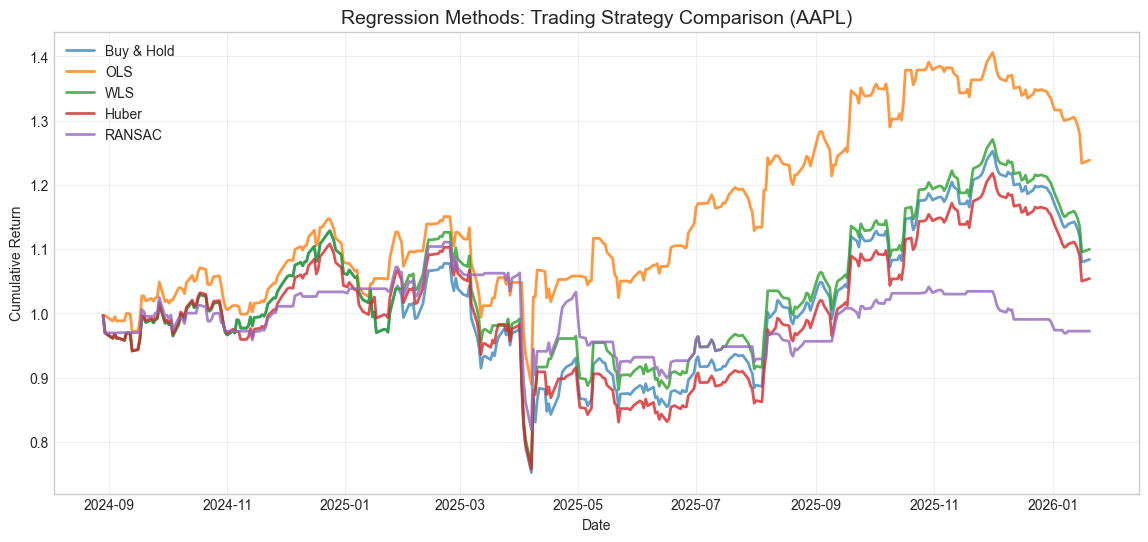

In [9]:
# Trading Strategy Backtest
backtest = pd.DataFrame(index=y_test.index)
backtest['actual'] = y_test.values

for name, pred in predictions.items():
    backtest[f'{name}_signal'] = np.where(pred > 0, 1, 0)
    backtest[f'{name}_return'] = backtest[f'{name}_signal'] * backtest['actual']
    backtest[f'{name}_cum'] = (1 + backtest[f'{name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2, alpha=0.7)
for name in predictions.keys():
    plt.plot(backtest.index, backtest[f'{name}_cum'], label=name, linewidth=2, alpha=0.8)
plt.title(f'Regression Methods: Trading Strategy Comparison ({target})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Performance comparison
def calc_sharpe(returns, rf=RISK_FREE_RATE):
    excess = returns.mean() * TRADING_DAYS - rf
    vol = returns.std() * np.sqrt(TRADING_DAYS)
    return excess / vol if vol > 0 else 0

def max_drawdown(cumulative):
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    return dd.min()

print("\n" + "="*70)
print("STRATEGY PERFORMANCE METRICS")
print("="*70)

print(f"\n{'Strategy':<15} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 50)
print(f"{'Buy & Hold':<15} {backtest['buy_hold_cum'].iloc[-1]-1:>12.2%} {calc_sharpe(backtest['actual']):>10.2f} {max_drawdown(backtest['buy_hold_cum']):>10.2%}")

for name in predictions.keys():
    ret = backtest[f'{name}_cum'].iloc[-1] - 1
    sharpe = calc_sharpe(backtest[f'{name}_return'])
    mdd = max_drawdown(backtest[f'{name}_cum'])
    print(f"{name:<15} {ret:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE METRICS

Strategy           Total Ret     Sharpe     Max DD
--------------------------------------------------
Buy & Hold             8.38%       0.17    -33.36%
OLS                   23.84%       0.53    -22.71%
WLS                    9.96%       0.21    -32.34%
Huber                  5.41%       0.10    -31.66%
RANSAC                -2.78%      -0.19    -26.31%


In [11]:
# Next Day Prediction
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTIONS FOR {target}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

for name, model_func in models.items():
    pred = model_func(latest_scaled)[0]
    signal = '📈 LONG' if pred > 0 else '📉 STAY OUT'
    print(f"{name:<12}: {pred:>10.4%} → {signal}")

# Current volatility context
current_vol = df['rolling_vol'].iloc[-1] * np.sqrt(TRADING_DAYS)
avg_vol = df['rolling_vol'].mean() * np.sqrt(TRADING_DAYS)
print(f"\n📊 Current Volatility: {current_vol:.1%} (Avg: {avg_vol:.1%})")
print(f"   {'⚠️ High volatility regime - WLS/Robust may be preferred' if current_vol > avg_vol else '✅ Normal volatility'}")


📊 NEXT DAY PREDICTIONS FOR AAPL

Date: 2026-01-20


ValueError: shapes (1,5) and (6,) not aligned: 5 (dim 1) != 6 (dim 0)

---

## 🏢 Real-World Applications

| Company | Robust/WLS Use Case |
|---------|-----------------------|
| Citadel | WLS for volatility-weighted signals |
| Jane Street | Robust regression for market making |
| Two Sigma | Outlier-resistant alpha models |
| D.E. Shaw | Regime-adaptive weighting |

### Key Interview Points
1. **When WLS?** - Known heteroscedasticity, want to downweight volatile periods
2. **When Huber?** - Moderate outliers, want L2 efficiency with L1 robustness
3. **Epsilon choice?** - Default 1.35 gives 95% efficiency for normal data

---
## 📅 Tomorrow: Week 5.1 Review & Interview Prep